In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import statsmodels.tools as sm
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, recall_score, roc_auc_score
#data manipulation and visualization libraries
#for not showing warnings
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

#libraries for modelling and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix,classification_report,roc_auc_score,roc_curve

In [245]:
#importing the data and making a dataframe
data=pd.read_excel("sample_final.xlsx")

In [246]:
data.head()

,Random,ad_instance_id,segment_id_x,place_id,user_action_id,action_time,screen_height,screen_width,segment_id_y,User_ID,mac_address
0,0.096644,2021,6,9,0,0,667,375,11,223481,1
1,0.522710,1108,6,47,-1,1,667,375,4,795536,1
2,0.434067,2747,6,27,0,0,640,360,5,938974,0
3,0.435501,2237,6,77,0,0,640,360,11,111971,0
4,0.250964,2306,14,46,0,0,640,360,4,421991,0


In [247]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299999 entries, 0 to 299998
Data columns (total 11 columns):
Random            299999 non-null float64
ad_instance_id    299999 non-null int64
segment_id_x      299999 non-null int64
place_id          299999 non-null int64
user_action_id    299999 non-null int64
action_time       299999 non-null int64
screen_height     299999 non-null int64
screen_width      299999 non-null int64
segment_id_y      299999 non-null int64
User_ID           299999 non-null int64
mac_address       299999 non-null int64
dtypes: float64(1), int64(10)
memory usage: 25.2 MB


In [248]:
data=data.drop("Random", axis=1)

In [249]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 94681
Missing values: 0
Single valued columns: Index([], dtype='object')


In [250]:
data.nunique()

ad_instance_id      544
segment_id_x         19
place_id            202
user_action_id        3
action_time           2
screen_height       207
screen_width        143
segment_id_y         15
User_ID           46614
mac_address           3
dtype: int64

In [251]:
data.user_action_id=np.where(data.user_action_id==1,1,0)

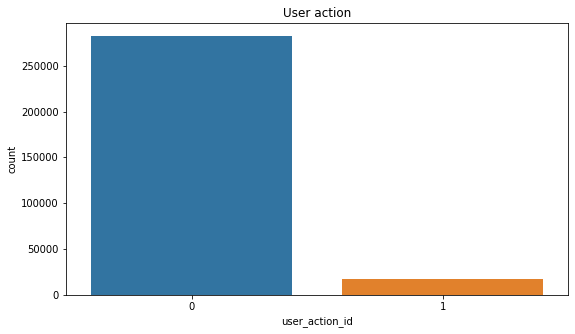

In [252]:
#let's visualise the distribution of y
plt.figure(figsize=(9,5))
sns.countplot(data.user_action_id)
plt.title("User action")
plt.show()

In [253]:
data.user_action_id.value_counts(normalize=True).mul(100).rename("User Action")

0    94.118314
1     5.881686
Name: User Action, dtype: float64

In [254]:
list(data.screen_width).count(0)

25

In [255]:
list(data.screen_height).count(0)

25

In [256]:
 mode_screen_height=data["screen_height"].mode()

In [257]:
 mode_screen_width=data["screen_width"].mode()

In [258]:
data.screen_height.replace([0], [mode_screen_height], inplace=True)

In [259]:
data.screen_width.replace([0], [mode_screen_width], inplace=True)

In [260]:
data["Screen_Area"]=data["screen_height"]*data["screen_width"]

In [263]:
list(data.screen_height).count(0)

0

In [264]:
list(data.screen_width).count(0)

0

In [265]:
data["Height_minus_Width"]=data["screen_height"]-data["screen_width"]

In [269]:
data["Rotate"]=np.where(data.Height_minus_Width<=0,1,0)

In [270]:
data.head()

,ad_instance_id,segment_id_x,place_id,user_action_id,action_time,screen_height,screen_width,segment_id_y,User_ID,mac_address,Screen_Area,Height_minus_Width,Rotate
0,2021,6,9,0,0,667,375,11,223481,1,250125,292,0
1,1108,6,47,0,1,667,375,4,795536,1,250125,292,0
2,2747,6,27,0,0,640,360,5,938974,0,230400,280,0
3,2237,6,77,0,0,640,360,11,111971,0,230400,280,0
4,2306,14,46,0,0,640,360,4,421991,0,230400,280,0


In [271]:
data_tr=data

In [272]:
data_tr.head()

,ad_instance_id,segment_id_x,place_id,user_action_id,action_time,screen_height,screen_width,segment_id_y,User_ID,mac_address,Screen_Area,Height_minus_Width,Rotate
0,2021,6,9,0,0,667,375,11,223481,1,250125,292,0
1,1108,6,47,0,1,667,375,4,795536,1,250125,292,0
2,2747,6,27,0,0,640,360,5,938974,0,230400,280,0
3,2237,6,77,0,0,640,360,11,111971,0,230400,280,0
4,2306,14,46,0,0,640,360,4,421991,0,230400,280,0


In [273]:
data_tr.nunique()

ad_instance_id          544
segment_id_x             19
place_id                202
user_action_id            2
action_time               2
screen_height           206
screen_width            142
segment_id_y             15
User_ID               46614
mac_address               3
Screen_Area             252
Height_minus_Width      239
Rotate                    2
dtype: int64

In [274]:
data_tr=data_tr.drop({"screen_height","screen_width","Height_minus_Width"}, axis=1)

In [275]:
data_tr.head()

,ad_instance_id,segment_id_x,place_id,user_action_id,action_time,segment_id_y,User_ID,mac_address,Screen_Area,Rotate
0,2021,6,9,0,0,11,223481,1,250125,0
1,1108,6,47,0,1,4,795536,1,250125,0
2,2747,6,27,0,0,5,938974,0,230400,0
3,2237,6,77,0,0,11,111971,0,230400,0
4,2306,14,46,0,0,4,421991,0,230400,0


In [276]:
pt_countadshown=pd.pivot_table(data=data_tr,index="User_ID", values="user_action_id",aggfunc="count", fill_value=0)

In [277]:
pt_countadshown.head()

,user_action_id
User_ID,
0,6
7,1
56,3
57,1
64,3


In [278]:
pt_countadclick=pd.pivot_table(data=data_tr,index="User_ID",values="user_action_id",aggfunc=sum, fill_value=0)

In [279]:
pt_countadclick.head()

,user_action_id
User_ID,
0,0
7,0
56,3
57,0
64,0


In [280]:
df = pd.DataFrame(pt_countadshown.to_records())

In [281]:
df.head()

,User_ID,user_action_id
0,0,6
1,7,1
2,56,3
3,57,1
4,64,3


In [282]:
df.rename(columns={'user_action_id': 'count_ad_shown'}, inplace=True)

In [283]:
df.head()

,User_ID,count_ad_shown
0,0,6
1,7,1
2,56,3
3,57,1
4,64,3


In [284]:
df2 = pd.DataFrame(pt_countadclick.to_records())

In [285]:
df2.rename(columns={'user_action_id': 'count_ad_click'}, inplace=True)

In [286]:
df2.head()

,User_ID,count_ad_click
0,0,0
1,7,0
2,56,3
3,57,0
4,64,0


In [287]:
df['count_ad_click']=df2.count_ad_click

In [288]:
df.head()

,User_ID,count_ad_shown,count_ad_click
0,0,6,0
1,7,1,0
2,56,3,3
3,57,1,0
4,64,3,0


In [289]:
pt_screen_area=pd.pivot_table(data=data_tr,index="User_ID", values="Screen_Area", fill_value=0)
pt_screen_area.head()

,Screen_Area
User_ID,
0,250125.0
7,230400.0
56,301584.0
57,250125.0
64,250125.0


In [290]:
df3 = pd.DataFrame(pt_screen_area.to_records())

In [291]:
df['screen_area']=df3.Screen_Area

In [292]:
df.head()

,User_ID,count_ad_shown,count_ad_click,screen_area
0,0,6,0,250125.0
1,7,1,0,230400.0
2,56,3,3,301584.0
3,57,1,0,250125.0
4,64,3,0,250125.0


In [293]:
df["percentage_ad_click"]=df.count_ad_click/df.count_ad_shown*100
df.head()

,User_ID,count_ad_shown,count_ad_click,screen_area,percentage_ad_click
0,0,6,0,250125.0,0.0
1,7,1,0,230400.0,0.0
2,56,3,3,301584.0,100.0
3,57,1,0,250125.0,0.0
4,64,3,0,250125.0,0.0


In [294]:
pt_segment=pd.pivot_table(data=data_tr,index="User_ID",columns="segment_id_x", values="user_action_id",aggfunc=sum, fill_value=0)

In [295]:
pt_segment.head()

segment_id_x,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
User_ID,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
56,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0
57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
64,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [296]:
df4 = pd.DataFrame(pt_segment.to_records())
df5=df4.drop("User_ID", axis=1)

In [297]:
for i in df5:
    df5[i]=np.where(df5[i]>0,1,0)

In [298]:
findata = pd.concat([df, df5], axis=1)
findata.head()

,User_ID,count_ad_shown,count_ad_click,screen_area,percentage_ad_click,1,2,3,4,5,...,10,11,12,13,14,15,16,17,18,19
0,0,6,0,250125.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,1,0,230400.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,56,3,3,301584.0,100.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,57,1,0,250125.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,64,3,0,250125.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [299]:
# the next step will be to predict whether user will click to certain segment(one of the segments) ads or not   

In [300]:
#finding popular ad segments to build a model and make predictions for them
for i in df5:
    print("Segment "+i+": ",df5[i].eq(1).sum())

Segment 1:  22
Segment 2:  218
Segment 3:  180
Segment 4:  0
Segment 5:  1040
Segment 6:  7361
Segment 7:  533
Segment 8:  541
Segment 9:  15
Segment 10:  4
Segment 11:  203
Segment 12:  178
Segment 13:  75
Segment 14:  56
Segment 15:  7
Segment 16:  15
Segment 17:  245
Segment 18:  30
Segment 19:  10


In [301]:
findata.isna().sum()

User_ID                0
count_ad_shown         0
count_ad_click         0
screen_area            0
percentage_ad_click    0
1                      0
2                      0
3                      0
4                      0
5                      0
6                      0
7                      0
8                      0
9                      0
10                     0
11                     0
12                     0
13                     0
14                     0
15                     0
16                     0
17                     0
18                     0
19                     0
dtype: int64

In [303]:
data_final1=findata[["count_ad_shown","count_ad_click","screen_area","percentage_ad_click","8"]]
data_final1["count_ad_shown"]=data_final1["count_ad_shown"]-df4["8"]
data_final1["count_ad_click"]=data_final1["count_ad_click"]-df4["8"]
data_final1["percentage_ad_click"]=data_final1["count_ad_click"]/data_final1["count_ad_shown"]*100
data_final1["percentage_ad_click"]=data_final1["percentage_ad_click"].fillna(0)

In [304]:
data_final1.head()

,count_ad_shown,count_ad_click,screen_area,percentage_ad_click,8
0,6,0,250125.0,0.0,0
1,1,0,230400.0,0.0,0
2,3,3,301584.0,100.0,0
3,1,0,250125.0,0.0,0
4,3,0,250125.0,0.0,0


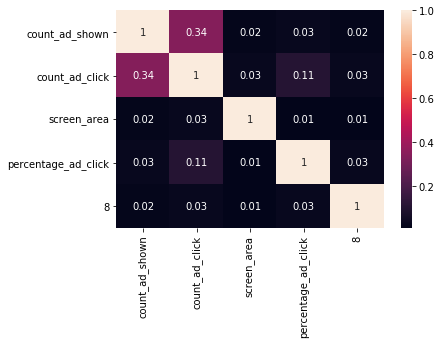

In [305]:
sns.heatmap(data_final1.corr().abs().round(2),annot=True)
plt.show()

In [306]:
Y=data_final1["8"]
X=data_final1.drop("8", axis=1)

In [307]:
X0, X1, Y0, Y1= train_test_split(X, Y, test_size=0.25, random_state=42)

## Logit

In [308]:
param_logit={'class_weight':[None,'balanced'],
            'C':np.linspace(0.0001,5,120)}

In [309]:
gridsearch_logit = GridSearchCV(estimator=LogisticRegression(random_state=42),
                        param_grid=param_logit,
                        cv=3,scoring='roc_auc',verbose=1)
gridsearch_logit.fit(X0,Y0)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 720 out of 720 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000000e...
       4.36976050e+00, 4.41177647e+00, 4.45379244e+00, 4.49580840e+00,
       4.53782437e+00, 4.57984034e+00, 4.62185630e+00, 4.66387227e+00,
       4.70588824e+00, 4.74790420e+00, 4.78992017e+00, 4.83193613e+00,
       4.87395210e+00, 4.91596807e+00, 4.95798403e+00, 5.00000000e+00]),
       

In [310]:
gridsearch_logit.best_params_

{'C': 0.5042915966386554, 'class_weight': 'balanced'}

In [311]:
logit=LogisticRegression(class_weight='balanced',C=0.5042915966386554,random_state=42).fit(X0,Y0)

In [312]:
Y0_logit=logit.predict_proba(X0)[:,1]
Y1_logit=logit.predict_proba(X1)[:,1]

In [313]:
print("ROC_AUC Train Logit:",roc_auc_score(Y0,Y0_logit).round(2))
print("ROC_AUC Test Logit:",roc_auc_score(Y1,Y1_logit).round(2))
print("Mean 3-fold ROC AUC score for logit:",np.mean(cross_val_score(estimator=logit, X=X,y=Y,cv=3, scoring="roc_auc")).round(2))

ROC_AUC Train Logit: 0.56
ROC_AUC Test Logit: 0.6
Mean 3-fold ROC AUC score for logit: 0.59


## DT

In [315]:
param_dt={"max_depth":range(3,15),"min_samples_leaf":range(20,120,5),
          "class_weight":["balanced", None],}

In [316]:
gs_dt=GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_grid=param_dt,scoring="roc_auc",cv=3, verbose=1)
gs_dt.fit(X0,Y0)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:  1.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': range(3, 15),
                         

In [317]:
gs_dt.best_params_

{'class_weight': None, 'max_depth': 5, 'min_samples_leaf': 55}

In [318]:
dt_grid=DecisionTreeClassifier(class_weight=None,max_depth=5,
                             min_samples_leaf=55, random_state=42).fit(X0,Y0)

Y0_dt_grid=dt_grid.predict_proba(X0)[:,1]
Y1_dt_grid=dt_grid.predict_proba(X1)[:,1]

In [319]:
print("ROC_AUC Train for Decision Tree:",roc_auc_score(Y0,Y0_dt_grid).round(2))
print("ROC_AUC Test for Decision Tree:",roc_auc_score(Y1,Y1_dt_grid).round(2))
print("Mean 3-fold ROC AUC score for Decision Tree:",np.mean(cross_val_score(estimator=dt_grid, X=X,y=Y,cv=3, scoring="roc_auc")).round(2))

ROC_AUC Train for Decision Tree: 0.78
ROC_AUC Test for Decision Tree: 0.78
Mean 3-fold ROC AUC score for Decision Tree: 0.77


In [320]:
#making a dataframe for convenient usage
feat_imp=pd.DataFrame(dt_grid.feature_importances_,index=X.columns,
                      columns=["Feature_imp"])
feat_imp=feat_imp.sort_values(by="Feature_imp",ascending=False)
feat_imp.head()

,Feature_imp
count_ad_shown,0.970750
count_ad_click,0.021346
percentage_ad_click,0.006195
screen_area,0.001710


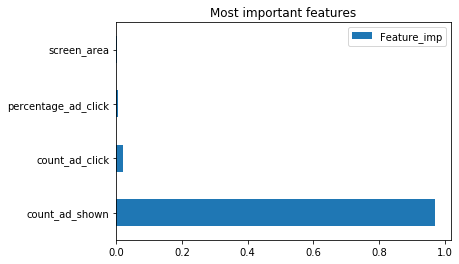

In [321]:
#visualizing feature importances
feat_imp.head(7).plot.barh()
plt.title("Most important features")
plt.show()

## RF

In [322]:
param_rf={  'max_depth': range(3,15),
            'min_samples_leaf': range(15, 95, 5),
             'class_weight': ['balanced', None] }

In [323]:
gs_rf=GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                   param_grid=param_rf,cv=3, scoring="roc_auc", verbose=1)
gs_rf.fit(X0,Y0)

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1152 out of 1152 | elapsed:  2.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [324]:
gs_rf.best_params_

{'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 35}

In [325]:
rf=RandomForestClassifier(random_state=42,class_weight=None,max_depth=3,min_samples_leaf=35).fit(X0,Y0)

#getting probabilities
Y0_rf=rf.predict_proba(X0)[:,1]
Y1_rf=rf.predict_proba(X1)[:,1]

In [326]:
print("ROC_AUC Train for Random Forest:",roc_auc_score(Y0,Y0_rf).round(2))
print("ROC_AUC Test for Random Forest:",roc_auc_score(Y1,Y1_rf).round(2))
#Mean cross val score for model with default hyperparameters
print("Mean 3-fold ROC AUC score for Random Forest:",np.mean(cross_val_score(estimator=rf, X=X,y=Y,cv=3, scoring="roc_auc",)).round(2))

ROC_AUC Train for Random Forest: 0.78
ROC_AUC Test for Random Forest: 0.78
Mean 3-fold ROC AUC score for Random Forest: 0.79


### building model without count_ad_shown :the most important variable of DT (97%)

In [339]:
# as there can be hidden affect on belongness to segment, 
# as the more ads you show to user the higher is the chance of clicking to the ads of particular segment

In [327]:
data_final2=data_final1.drop("count_ad_shown", axis=1)

In [328]:
Y_2=data_final2["8"]
X_2=data_final2.drop("8", axis=1)

In [329]:
X0_2, X1_2, Y0_2, Y1_2= train_test_split(X_2, Y_2, test_size=0.25, random_state=42)

## DT2

In [331]:
param_dt_2={"max_depth":range(3,15),"min_samples_leaf":range(20,120,5),
          "class_weight":["balanced", None],}

In [332]:
gs_dt_2=GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   param_grid=param_dt_2,scoring="roc_auc",cv=3, verbose=1)
gs_dt_2.fit(X0_2,Y0_2)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:   41.6s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': range(3, 15),
                         

In [333]:
gs_dt_2.best_params_

{'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 115}

In [334]:
dt_grid_2=DecisionTreeClassifier(class_weight='balanced',max_depth=5,
                             min_samples_leaf=115, random_state=42).fit(X0_2,Y0_2)

Y0_dt_grid_2=dt_grid_2.predict_proba(X0_2)[:,1]
Y1_dt_grid_2=dt_grid_2.predict_proba(X1_2)[:,1]

In [335]:
print("ROC_AUC Train for Decision Tree 2:",roc_auc_score(Y0_2,Y0_dt_grid_2).round(2))
print("ROC_AUC Test for Decision Tree 2:",roc_auc_score(Y1_2,Y1_dt_grid_2).round(2))
print("Mean 3-fold ROC AUC score for Decision Tree 2:",np.mean(cross_val_score(estimator=dt_grid_2, X=X_2,y=Y_2,cv=3, scoring="roc_auc")).round(2))

ROC_AUC Train for Decision Tree 2: 0.67
ROC_AUC Test for Decision Tree 2: 0.69
Mean 3-fold ROC AUC score for Decision Tree 2: 0.65


In [336]:
feat_imp_2=pd.DataFrame(dt_grid_2.feature_importances_,index=X_2.columns,
                      columns=["Feature_imp"])
feat_imp_2=feat_imp_2.sort_values(by="Feature_imp",ascending=False)
feat_imp_2.head()

,Feature_imp
screen_area,0.587658
count_ad_click,0.318553
percentage_ad_click,0.093788


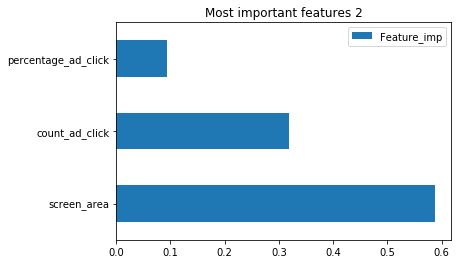

In [337]:
#visualizing feature importances
feat_imp_2.head(7).plot.barh()
plt.title("Most important features 2")
plt.show()